In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon

In [3]:
t_start = Time("2024-10-01", format='isot')
t_end = Time(t_start.mjd + 3650, format='mjd')
times = np.arange(t_start.mjd, t_end.mjd, 30)
loc = EarthLocation.of_site('cerro pachon') 

In [4]:
with solar_system_ephemeris.set('de432s'):
    jup = get_body('jupiter', Time(times, format='mjd'), loc)
    mars = get_body('mars', Time(times, format='mjd'), loc)
    saturn = get_body('saturn', Time(times, format='mjd'), loc)

/Users/lynnej/anaconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 94 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/lynnej/anaconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 94 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/lynnej/anaconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 94 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [5]:
from rubin_sim.utils import calcSeason

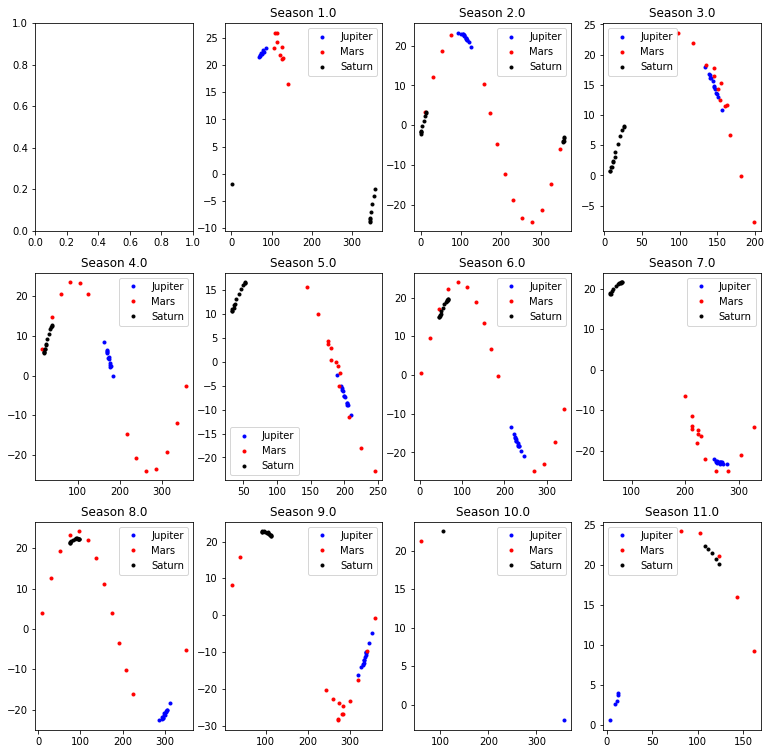

In [6]:
years = np.floor((times - t_start.mjd) / 365) + 1
seasons = calcSeason(jup.ra.deg, times)
seasons = np.floor(seasons) + 1
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(ncols=4, nrows=3)
axs = gs.subplots()
for yr in np.unique(seasons):
    yy = np.where(seasons == yr)
    ax = axs[int(yr // 4)][int(yr % 4)]
    ax.plot(jup.ra.deg[yy], jup.dec.deg[yy], 'b.', label='Jupiter')
    ax.plot(mars.ra.deg[yy], mars.dec.deg[yy], 'r.', label='Mars')
    ax.plot(saturn.ra.deg[yy], saturn.dec.deg[yy], 'k.', label='Saturn')
    ax.legend()
    ax.set_title(f'Season {yr}')

In [7]:
import healpy as hp
from rubin_sim.scheduler.utils import Sky_area_generator, slice_wfd_area_quad

In [8]:
footprint = Sky_area_generator()
maps, labels = footprint.return_maps()
np.unique(labels)
wfdhp = np.where(labels=='lowdust')[0]
splitIndx = slice_wfd_area_quad(maps, nslice=2, wfd_indx=wfdhp)

In [9]:
splitIndx[-1] = splitIndx[-1] - 1
splitIndx

[0, 1305, 2610, 3915, 5220]

In [10]:
footprint.dec[wfdhp[splitIndx]]

array([ 14.47751219,  -4.78019185, -20.74237995, -38.68218745,
       -69.42254649])

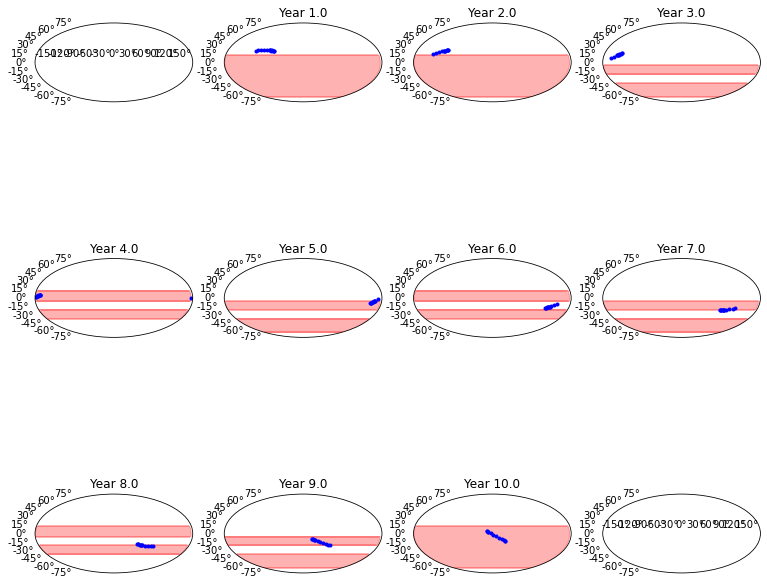

In [11]:
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(ncols=4, nrows=3, hspace=0)
axs = gs.subplots(subplot_kw={'projection':'mollweide'})
for i, yr in enumerate(np.unique(years)):
    yy = np.where(years == yr)
    ax = axs[int(yr // 4)][int(yr % 4)]
    declines = np.radians(footprint.dec[wfdhp[splitIndx]])
    for j, dec in enumerate(declines):
        color = 'b'
        if i in [0, 1, 9, 10, 11]:
            color = 'b'
        elif i % 2 == 1:
            if j == 0 or j == 1:
                color = 'r'
        else:
            if j == 1 or j == 2:
                color='r'
        #ax.axhline(dec, color=color)
    if i in [0, 1, 9, 10, 11]:
        ax.fill_between(x=np.arange(-np.pi, np.pi, 0.1),
                       y1=declines[0], y2=declines[-1], color='r', alpha=0.3)
    elif i % 2 == 1:
        ax.fill_between(x=np.arange(-np.pi, np.pi, 0.1), 
                       y1=declines[0], y2=declines[1], color='r', alpha=0.3)
        ax.fill_between(x=np.arange(-np.pi, np.pi, 0.1),
                       y1=declines[2], y2=declines[3], color='r', alpha=0.3)
    else:
        ax.fill_between(x=np.arange(-np.pi, np.pi, 0.1), 
                       y1=declines[1], y2=declines[2], color='r', alpha=0.3)
        ax.fill_between(x=np.arange(-np.pi, np.pi, 0.1),
                       y1=declines[3], y2=declines[4], color='r', alpha=0.3)
    lon = (-(jup.ra.rad[yy] - np.pi) % (np.pi * 2) - np.pi)
    ax.plot(lon, 
            jup.dec.rad[yy], 'b.', label='Jupiter')
    #ax.plot(mars.ra.rad[yy], mars.dec.rad[yy], 'r.', label='Mars')
    #ax.plot(saturn.ra.rad[yy], saturn.dec.rad[yy], 'k.', label='Saturn')
    ax.xaxis.set_ticklabels([])
    #ax.legend()
    ax.set_title(f'Year {yr}')